In [8]:
# Initializing Library
import pandas
import numpy as np
from numpy import mean
from numpy import std
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from pandas import set_option
from collections import Counter
from matplotlib import pyplot

In [3]:
# Load the dataframe
df = pandas.read_csv("data/data.csv", header=0)
# Convert the Burn Severity into a Catagorical Variable
# df['BS'] = pandas.cut(df['burnseverity20200906vs20201015'], bins=[-0.1,0.1,0.27,0.66,1.31,float('inf')],labels=[1, 2, 3, 4, 0])
# Deleting unnecessery columns
df = df.drop(['ID','x','y'], axis = 1)
# Removing all NA fields
df = df.dropna()
# Remove Na values of Burn Severity from layer column
df = df[df.layer != 0]
# describe the dataset
set_option('precision', 3)
print(df.describe())

             zmax       zmean         zsd       zskew       zkurt    zentropy  \
count  106908.000  106908.000  106908.000  106908.000  106908.000  106908.000   
mean     1099.406    1063.646      10.255       0.329      28.190       0.495   
std       204.843     195.997       3.806       2.537     229.361       0.063   
min       547.125     520.070       0.022      -4.418       1.000       0.000   
25%       963.762     933.397       7.575      -0.368       2.097       0.465   
50%      1089.929    1059.283       9.776      -0.015       2.423       0.498   
75%      1200.932    1162.254      12.716       0.384       2.895       0.537   
max      2361.730    1648.917     237.629      86.419   10766.437       0.665   

       pzabovezmean  pzabove2         zq5        zq10  ...    zpcum1  \
count    106908.000  106908.0  106908.000  106908.000  ...  106908.0   
mean         51.356     100.0    1047.380    1049.607  ...       0.0   
std           6.723       0.0     197.225     196.966 

Class=3.0, Count=36903, Percentage=34.518%
Class=2.0, Count=28493, Percentage=26.652%
Class=1.0, Count=41512, Percentage=38.830%


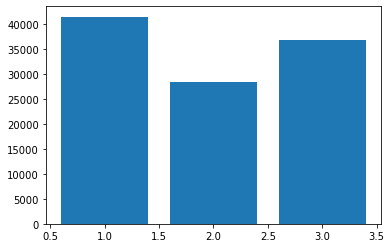

In [4]:
# summarize the class distribution
target = df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [5]:
# Data preperation
# Function to prepare the dataset
def prep_dataset(df):
	# retrieve numpy array
	dataset = df.values
	# split into input (X) and output (y) variables
	X = dataset[:, :-1]
	y = dataset[:,-1]
	# Return X,y values
	return X, y
# Names of the features from the header as list
names = df.columns.tolist()
# removing the Output Var name from the list
names = names[:-1]
print(names)
#print(len(df.columns))
#print(df['BS'].isnull().values.any())
# load the dataset
X, y = prep_dataset(df)
# Convert y as multiclass label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X.shape

['zmax', 'zmean', 'zsd', 'zskew', 'zkurt', 'zentropy', 'pzabovezmean', 'pzabove2', 'zq5', 'zq10', 'zq15', 'zq20', 'zq25', 'zq30', 'zq35', 'zq40', 'zq45', 'zq50', 'zq55', 'zq60', 'zq65', 'zq70', 'zq75', 'zq80', 'zq85', 'zq90', 'zq95', 'zpcum1', 'zpcum2', 'zpcum3', 'zpcum4', 'zpcum5', 'zpcum6', 'zpcum7', 'zpcum8', 'zpcum9']


(106908, 36)

Feature name zmax: 257.175395
Feature name zmean: 313.587067
Feature name zsd: 711.126190
Feature name zskew: 144.315052
Feature name zkurt: 7.133150
Feature name zentropy: 363.657069
Feature name pzabovezmean: 2333.287295
Feature name pzabove2: nan
Feature name zq5: 324.358528
Feature name zq10: 318.357683
Feature name zq15: 315.573812
Feature name zq20: 315.429977
Feature name zq25: 316.211035
Feature name zq30: 316.940534
Feature name zq35: 317.451076
Feature name zq40: 318.011687
Feature name zq45: 318.591877
Feature name zq50: 318.904521
Feature name zq55: 318.687387
Feature name zq60: 317.753665
Feature name zq65: 316.222165
Feature name zq70: 314.152765
Feature name zq75: 311.546816
Feature name zq80: 308.518817
Feature name zq85: 304.822026
Feature name zq90: 300.229335
Feature name zq95: 293.940821
Feature name zpcum1: nan
Feature name zpcum2: nan
Feature name zpcum3: 5.949648
Feature name zpcum4: 6.990458
Feature name zpcum5: 14.444927
Feature name zpcum6: 25.140673
Feature n

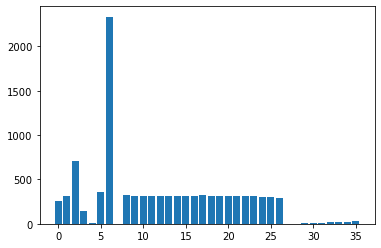

25

In [6]:
# define feature selection
fs = SelectKBest(score_func=f_classif, k='all').fit(X,y)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature name %s: %f' % (names[i], fs.scores_[i]))
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()
# Count Features which value is > 40
fs.scores_[(fs.scores_ > 40)].size

In [5]:
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
model = LogisticRegression(solver='liblinear')
fs = SelectKBest(score_func=f_classif)
pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
# define the grid
grid = dict()
grid['anova__k'] = [i+1 for i in range(X.shape[1])]
# define the grid search
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X, y)
# # summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

Best Mean Accuracy: 0.489
Best Config: {'anova__k': 36}


In [6]:
# Split-out trainging and testing dataset
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.30, random_state=1, shuffle=True)

In [10]:
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
#  define RF model to evaluate
model = RandomForestClassifier(n_estimators=1000)
# fit the model
model.fit(X_train, Y_train)
# evaluate the model and store results
scores = evaluate_model(X_validation, Y_validation, model)
print('>Mean Accuricy %.3f (%.3f)' % (mean(scores), std(scores)))

>Mean Accuricy 0.577 (0.004)


In [11]:
# Lets make a prediction
# known class "2.0" Low Burned
row = [1212.175537,1201.414185,3.744570017,0.025900438,2.527083158,0.309110761,51.14349365,100,1196.758057,1197.177246,1197.437256,1197.896973,1198.841553,1199.130127,1199.453979,1199.648071,1200.200073,1200.666382,1201.117188,1201.655151,1202.256958,1203.067627,1203.952515,1204.922974,1205.840088,1206.836426,1208.060669,0,0,0,0,0,0,0,0,0]
yhat = model.predict([row])
label = label_encoder.inverse_transform(yhat)[0]
print('>Predicted=%s (expected 2.0)' % (label))

>Predicted=2.0 (expected 2.0)


In [12]:
y_test_pred = cross_val_predict(model, X_validation, Y_validation)
conf_mx = confusion_matrix(Y_validation, y_test_pred)
conf_mx

array([[8873, 1439, 2282],
       [2642, 2814, 2968],
       [2449, 1803, 6803]], dtype=int64)

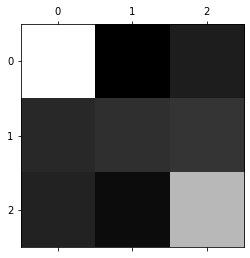

In [13]:
# ploting the confusion matrix
pyplot.matshow(conf_mx, cmap=pyplot.cm.gray)
#save_fig("confusion_matrix_plot", tight_layout=False)
pyplot.show()